In [1]:
import pandas as pd
import seaborn as sns
import csv
import numpy as np
import sklearn
import pickle
import xgboost as xgb
from IPython.display import display
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from time import time
import pylab as plb
import matplotlib.pyplot as plt

%matplotlib inline

In [119]:
original_data = pd.read_csv('full_dataset.csv')

original_data = original_data[original_data.MW > 3]

original_data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)
original_data.head()

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,...,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffLP
0,3420,09/08/2019,Liverpool,Norwich,4.0,1.0,H,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-16.0
1,3421,10/08/2019,West Ham,Man City,0.0,5.0,A,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,9.0
2,3422,10/08/2019,Bournemouth,Sheffield United,1.0,1.0,D,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-4.0
3,3423,10/08/2019,Burnley,Southampton,3.0,0.0,H,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,-1.0
4,3424,10/08/2019,Crystal Palace,Everton,0.0,0.0,D,0.0,0.0,0.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,4.0


In [101]:
# Total number of students.
n_matches = original_data.shape[0]

# Calculate number of features.
n_features = original_data.shape[1] - 1

# Calculate matches won by home team.
n_homewins = len(original_data[original_data.FTR == 'H'])

# Calculate win rate for home team.
win_rate = (float(n_homewins) / (n_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

original_data.dtypes

Total number of matches: 3407
Number of features: 12
Number of matches won by home team: 1575
Win rate of home team: 46.23%


FTR             object
HTP            float64
ATP            float64
HM1             object
HM2             object
HM3             object
AM1             object
AM2             object
AM3             object
HTGD           float64
ATGD           float64
DiffFormPts    float64
DiffLP         float64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002CD12ED5828>,
      dtype=object)

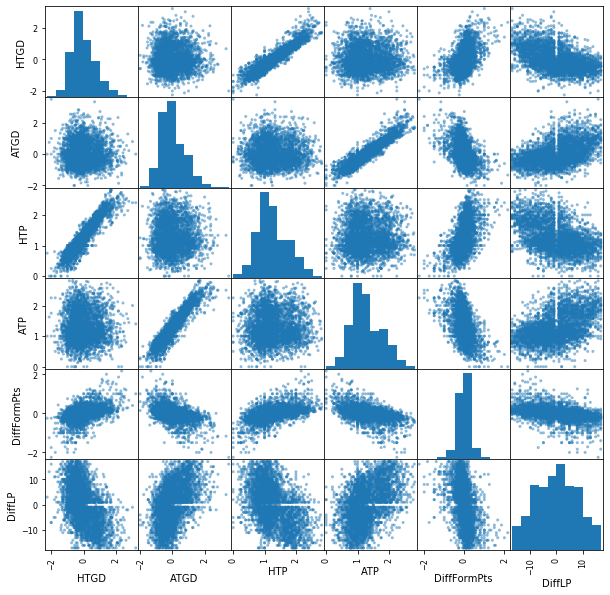

In [4]:
scatter_matrix(original_data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

In [102]:
x_set = original_data.drop(['FTR'],1)#.notna()
y_set = original_data['FTR']

print(x_set.shape)
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    x_set[col] = scale(x_set[col])

(3407, 12)


In [103]:
x_set.HM1 = x_set.HM1.astype('str')
x_set.HM2 = x_set.HM2.astype('str')
x_set.HM3 = x_set.HM3.astype('str')
x_set.AM1 = x_set.AM1.astype('str')
x_set.AM2 = x_set.AM2.astype('str')
x_set.AM3 = x_set.AM3.astype('str')

def preprocessing(x):
    output = pd.DataFrame(index = x.index)
    
    for col, col_data in x.iteritems():
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    return output

x_set = preprocessing(x_set)
print ("Processed feature columns ({} total features):\n{}".format(len(x_set.columns), list(x_set.columns)))

Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [113]:
x_train, x_test, y_train, y_test = train_test_split(x_set, y_set,
                                                    test_size = 50,
                                                    random_state = 2,
                                                    stratify = y_set)


In [114]:
def classifier_training(clf, x_train, y_train):
    start = time()
    clf.fit(x_train, y_train)
    end = time()
    
    print ("Trained model in {:.4f} seconds".format(end - start))
    
def labels_prediction(clf, features, target):
    start = time()
    y_prediction = clf.predict(features)
    end = time()
    
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_prediction, pos_label='H', average='micro'), sum(target == y_prediction) / float(len(y_prediction))

def train_predictor(clf, x_train, y_train, x_test, y_test):
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(x_train)))
    
    classifier_training(clf, x_train, y_train)
    
    f1, acc = labels_prediction(clf, x_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = labels_prediction(clf, x_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    

In [115]:
dectree = tree.DecisionTreeClassifier(criterion='entropy')
supvec = SVC(random_state = 912, kernel = 'rbf', gamma = 'scale')
lr = LogisticRegression(random_state = 42)
xgboost = xgb.XGBClassifier(seed = 82)

train_predictor(dectree, x_train, y_train, x_test, y_test)
print ('')
train_predictor(supvec, x_train, y_train, x_test, y_test)
print ('')
train_predictor(lr, x_train, y_train, x_test, y_test)
print ('')
train_predictor(xgboost, x_train, y_train, x_test, y_test)
print ('')

Training a DecisionTreeClassifier using a training set size of 3357. . .
Trained model in 0.1460 seconds
Made predictions in 0.0059 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0010 seconds.
F1 score and accuracy score for test set: 0.4400 , 0.4400.

Training a SVC using a training set size of 3357. . .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Trained model in 1.5364 seconds
Made predictions in 0.5631 seconds.
0.579088471849866 0.579088471849866
F1 score and accuracy score for training set: 0.5791 , 0.5791.
Made predictions in 0.0110 seconds.
F1 score and accuracy score for test set: 0.5000 , 0.5000.

Training a LogisticRegression using a training set size of 3357. . .
Trained model in 0.1120 seconds
Made predictions in 0.0140 seconds.
0.538576109621686

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning

 0.538576109621686
F1 score and accuracy score for training set: 0.5386 , 0.5386.
Made predictions in 0.0040 seconds.
F1 score and accuracy score for test set: 0.5000 , 0.5000.

Training a XGBClassifier using a training set size of 3357. . .


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Trained model in 2.9277 seconds
Made predictions in 0.0520 seconds.
0.9883824843610366 0.9883824843610366
F1 score and accuracy score for training set: 0.9884 , 0.9884.
Made predictions in 0.0050 seconds.
F1 score and accuracy score for test set: 0.4600 , 0.4600.



In [116]:
parameters = {'learning_rate': [0.04],
              'n_estimators': [30],
              'max_depth': [6],
              'min_child_weight': [6],
              'gamma': [0.4],
              'subsample': [0.8],
              'colsample_bytree': [0.8],
              'scale_pos_weight': [1.1],
              'reg_alpha': [1e-8]
             }

clf = xgb.XGBClassifier(seed=3)

f1_measure = make_scorer(f1_score,pos_label='H',average='micro')

grid = GridSearchCV(clf,
                    scoring=f1_measure,
                    param_grid=parameters,
                    cv=5)

grid = grid.fit(x_train,y_train)

clf = grid.best_estimator_
print (clf)

f1, acc = labels_prediction(clf, x_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))

f1, acc = labels_prediction(clf, x_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1259: UserWarning: Note that pos_label (set to 'H') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.04, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=30, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=3, reg_alpha=1e-08,
              reg_lambda=1, scale_pos_weight=1.1, seed=3, subsample=0.8,
              tree_method=None, validate_parameters=False, verbosity=None)
Made predictions in 0.0340 seconds.
F1 score and accuracy score for training set: 0.6181 , 0.6181.
Made predictions in 0.0050 seconds.
F1 score and accuracy score for test set: 0.5800 , 0.5800.


In [121]:
data_to_predict = pd.read_csv('test.csv')

data_to_predict = data_to_predict[data_to_predict.MW > 3]

data_to_predict.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)

data_to_predict.head()

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,D,0.75,1.00,W,L,L,L,D,W,-0.50,0.75,-0.25,10.0
31,D,1.00,1.00,W,D,L,L,W,D,-0.75,0.00,0.00,-15.0
32,H,1.00,0.75,W,L,D,W,L,L,0.00,-0.25,0.25,-6.0
33,H,1.25,1.00,W,D,D,L,W,D,0.25,-0.25,0.25,-5.0
34,H,1.75,1.00,W,D,W,L,D,W,1.75,0.25,0.75,-16.0


In [125]:
x_predset = data_to_predict.drop(['FTR'],1)
y_predset = data_to_predict['FTR']


cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    x_predset[col] = scale(x_predset[col])
    
y_predset

30       D
31       D
32       H
33       H
34       H
      ... 
375    NaN
376    NaN
377    NaN
378    NaN
379    NaN
Name: FTR, Length: 350, dtype: object

In [123]:
clf.predict(y_predset)

TypeError: can not initialize DMatrix from Series